# Neural Network Classification

## Prepare Classification Data

In [ ]:
import sklearn
from sklearn.datasets import make_circles

In [ ]:
n_samples = 1000

X, y =  make_circles(n_samples,
                     noise=0.03,
                     random_state=42)

len(X), len(y)

(1000, 1000)

In [ ]:
print(f"First 5 samples of X:\n{X[:5]}")
print(f"First 5 samples of y:\n{y[:5]}")

First 5 samples of X:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
[1 1 1 1 0]


In [ ]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


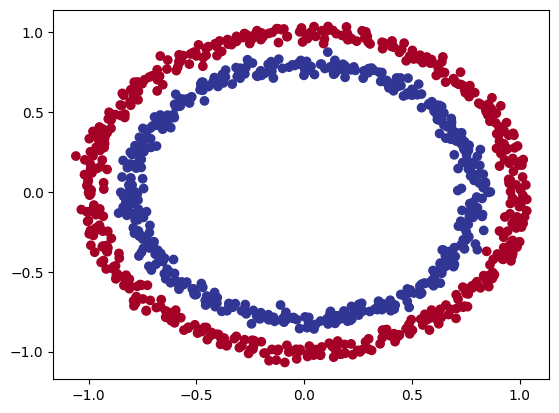

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

### Check Input and Output Shapes

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and y: {y_sample}")
print(f"Shape for one sample of X: {X_sample.shape} and y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and y: 1
Shape for one sample of X: (2,) and y: ()


### Turn Data into Tensors and Create Train and Test Splits

In [ ]:
import torch
torch.__version__

'2.0.1+cu118'

In [ ]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2)

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

 ## Build the Model

In [ ]:
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Construct a model that subclasses nn.Module

In [ ]:
X_train.shape

torch.Size([800, 2])

In [ ]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2, 
                             out_features=5)
    self.layer_2 = nn.Linear(in_features=5,
                             out_features=5)
    self.layer_3 = nn.Linear(in_features=5,
                             out_features=1)

  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x))) # x -> layer_1 -> layer_2 -> output

In [ ]:
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=5, bias=True)
  (layer_3): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [ ]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2,
              out_features=5),
    nn.Linear(in_features=5,
              out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.2385, -0.4515],
                      [-0.6360,  0.0460],
                      [ 0.4589,  0.6440],
                      [ 0.4126, -0.3665],
                      [-0.6993,  0.2682]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.3962, -0.6071,  0.2536,  0.5978,  0.0428], device='cuda:0')),
             ('1.weight',
              tensor([[-0.2694,  0.3667,  0.1910,  0.2961, -0.3024]], device='cuda:0')),
             ('1.bias', tensor([0.2603], device='cuda:0'))])

In [ ]:
untrained_preds = model_0(X_test.to(device))
torch.round(untrained_preds[:10])

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [-0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
X_test[:10], y_test[:10]

(tensor([[ 0.4184, -0.7335],
         [ 0.2985, -0.9833],
         [ 0.9921, -0.1861],
         [-0.0338, -0.7996],
         [-0.5798, -0.5968],
         [-0.5981, -0.5527],
         [ 0.7889, -0.0840],
         [ 0.9684, -0.3852],
         [ 0.6251, -0.8255],
         [ 0.8595, -0.5214]]),
 tensor([1., 0., 0., 1., 1., 1., 1., 0., 0., 0.]))

### Setup Loss Function and Optimizer

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [ ]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

## Train Model

### Raw Logits -> Prediction Probabilities ->  Prediction Labels

In [ ]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]

y_logits

tensor([[ 0.1963],
        [ 0.1481],
        [ 0.3805],
        [ 0.0774],
        [-0.0458]], device='cuda:0')

In [ ]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5489],
        [0.5370],
        [0.5940],
        [0.5193],
        [0.4885]], device='cuda:0')

In [ ]:
y_preds = torch.round(y_pred_probs)

y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 0.], device='cuda:0')

In [ ]:
y_test[:5]

tensor([1., 0., 0., 1., 1.])

### Build Training and Testing Loop

In [ ]:
!nvidia-smi

Sun May 21 22:08:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    30W /  70W |    821MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_0.train()

  # Forward Pass
  y_logits = model_0(X_train).squeeze().to(device)
  y_pred = torch.round(torch.sigmoid(y_logits)) # Turn logits into probabilities to labels

  # Calculate Loss/Accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  
  # Optimizer Zero Grad
  optimizer.zero_grad()

  # Loss Backward
  loss.backward()

  # Optimizer Step
  optimizer.step()

  # Testing
  model_0.eval()
  with torch.inference_mode():
    # Forward Pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # Calculate test loss/accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69679 | Acc: 53.87% | Test Loss: 0.70847 | Test Acc: 48.00%
Epoch: 10 | Loss: 0.69445 | Acc: 52.62% | Test Loss: 0.70391 | Test Acc: 45.50%
Epoch: 20 | Loss: 0.69365 | Acc: 52.88% | Test Loss: 0.70161 | Test Acc: 44.50%
Epoch: 30 | Loss: 0.69334 | Acc: 52.38% | Test Loss: 0.70027 | Test Acc: 44.00%
Epoch: 40 | Loss: 0.69318 | Acc: 52.50% | Test Loss: 0.69937 | Test Acc: 44.00%
Epoch: 50 | Loss: 0.69308 | Acc: 52.00% | Test Loss: 0.69873 | Test Acc: 43.50%
Epoch: 60 | Loss: 0.69302 | Acc: 51.88% | Test Loss: 0.69825 | Test Acc: 43.50%
Epoch: 70 | Loss: 0.69297 | Acc: 52.25% | Test Loss: 0.69787 | Test Acc: 43.50%
Epoch: 80 | Loss: 0.69294 | Acc: 52.25% | Test Loss: 0.69756 | Test Acc: 43.50%
Epoch: 90 | Loss: 0.69291 | Acc: 51.88% | Test Loss: 0.69731 | Test Acc: 43.50%


## Make Predictions and Evaluate Model

In [ ]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download!")
else:
  print("Downloading helper_functions.py!")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download!


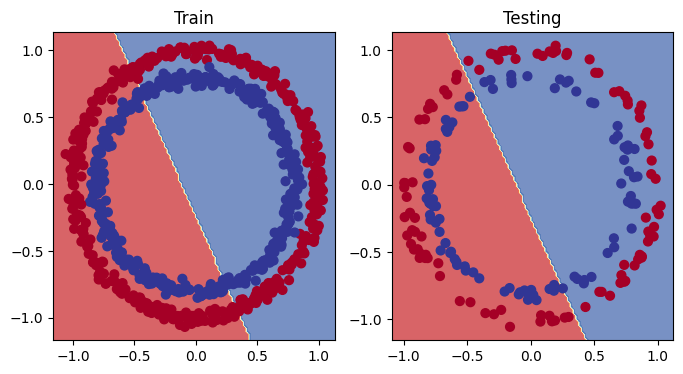

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Testing")
plot_decision_boundary(model_0, X_test, y_test)

## Improving a Model

In [ ]:
# Add more hidden units, increase number of layers, increase epochs
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x)))

In [ ]:
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Loss Function and Optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [ ]:
# Training Loop
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  # Forward Pass
  y_logits = model_1(X_train).squeeze().to(device)
  y_pred = torch.round(torch.sigmoid(y_logits))

  # Calculate Loss/Accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  
  # Optimizer zero grad
  optimizer.zero_grad()

  # Loss Backwards (Backpropagation)
  loss.backward()

  # Optimizer Step (Gradient Descent)
  optimizer.step()

  # Testing
  model_1.eval()
  with torch.inference_mode():
    # Forward Pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # Test Loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)
    
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70352, Acc: 49.62% | Test Loss: 0.69842, Test Acc: 51.50%
Epoch: 100 | Loss: 0.69292, Acc: 53.62% | Test Loss: 0.69454, Test Acc: 45.00%
Epoch: 200 | Loss: 0.69287, Acc: 53.12% | Test Loss: 0.69516, Test Acc: 44.50%
Epoch: 300 | Loss: 0.69285, Acc: 52.50% | Test Loss: 0.69552, Test Acc: 45.00%
Epoch: 400 | Loss: 0.69285, Acc: 52.62% | Test Loss: 0.69571, Test Acc: 44.50%
Epoch: 500 | Loss: 0.69285, Acc: 52.50% | Test Loss: 0.69582, Test Acc: 44.00%
Epoch: 600 | Loss: 0.69285, Acc: 52.38% | Test Loss: 0.69588, Test Acc: 44.00%
Epoch: 700 | Loss: 0.69284, Acc: 52.50% | Test Loss: 0.69591, Test Acc: 44.00%
Epoch: 800 | Loss: 0.69284, Acc: 52.50% | Test Loss: 0.69592, Test Acc: 44.00%
Epoch: 900 | Loss: 0.69284, Acc: 52.50% | Test Loss: 0.69593, Test Acc: 44.00%


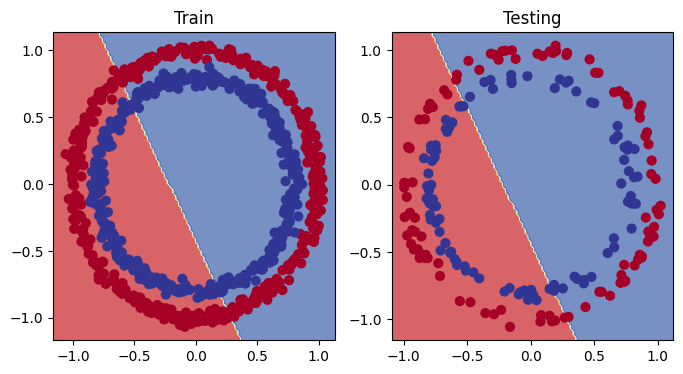

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Testing")
plot_decision_boundary(model_1, X_test, y_test)

### Preparing Data to See If Model Can Fit a Straight Line

In [ ]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [ ]:
# Create train and test split
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

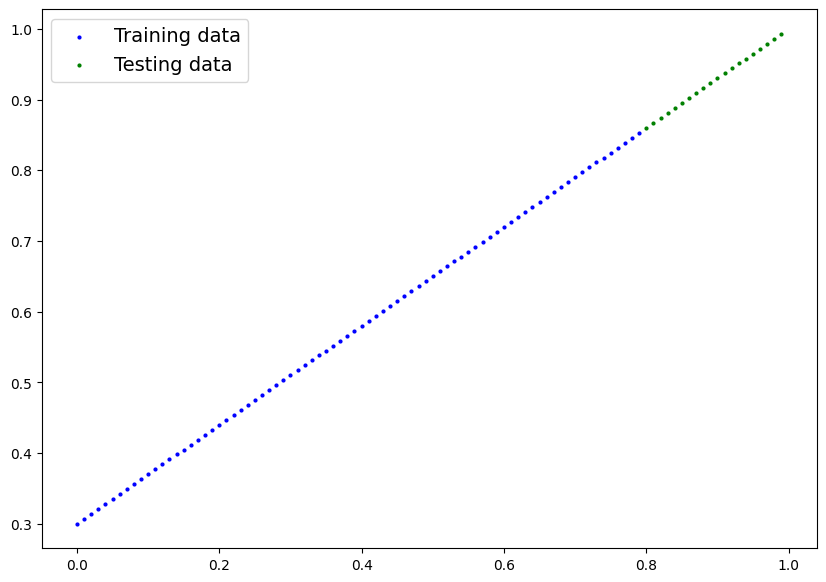

In [ ]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

### Adjusting model_1 to fit a straight line

In [ ]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Loss and Optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), 
                            lr=0.01)

In [ ]:
# Train model
epochs = 1000

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.61116 | Test Loss: 0.98358
Epoch: 100 | Loss: 0.07119 | Test Loss: 0.16327
Epoch: 200 | Loss: 0.04918 | Test Loss: 0.00657
Epoch: 300 | Loss: 0.04230 | Test Loss: 0.00604
Epoch: 400 | Loss: 0.03962 | Test Loss: 0.00781
Epoch: 500 | Loss: 0.03618 | Test Loss: 0.00640
Epoch: 600 | Loss: 0.03493 | Test Loss: 0.00740
Epoch: 700 | Loss: 0.03265 | Test Loss: 0.00669
Epoch: 800 | Loss: 0.03316 | Test Loss: 0.00553
Epoch: 900 | Loss: 0.03466 | Test Loss: 0.00714


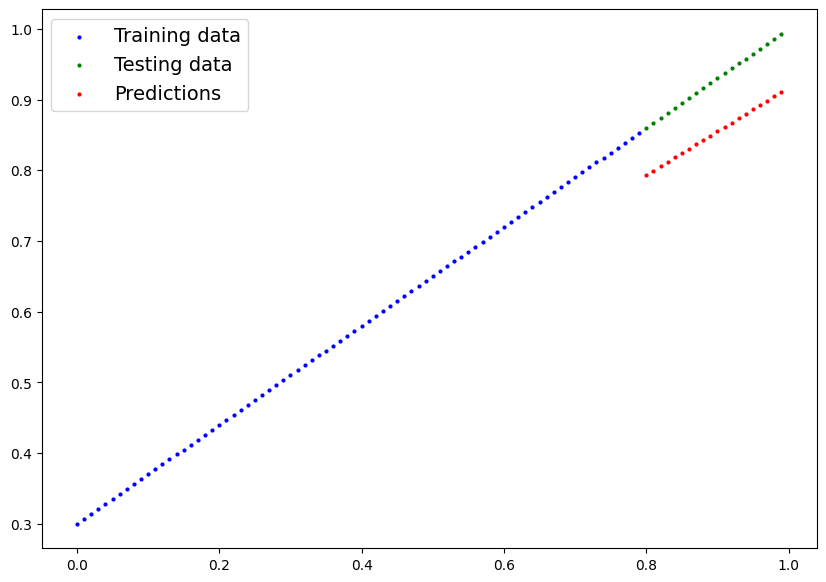

In [ ]:
model_2.eval()

with torch.inference_mode():
  y_preds = model_2(X_test_regression)

plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())

## Nonlinearity

### Recreating nonlinear data

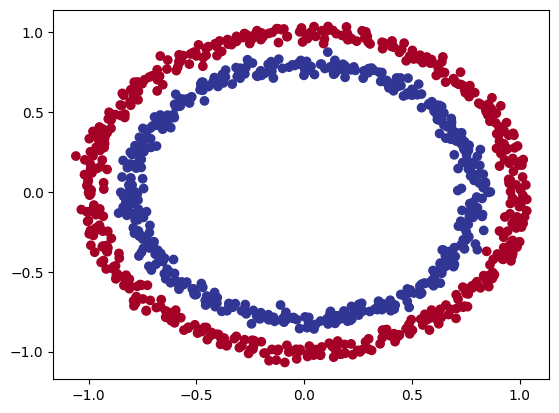

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [ ]:
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### Building a Model With Nonlinearity

In [ ]:
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=20)
    self.layer_2 = nn.Linear(in_features=20, out_features=20)
    self.layer_3 = nn.Linear(in_features=20, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [ ]:
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=20, bias=True)
  (layer_2): Linear(in_features=20, out_features=20, bias=True)
  (layer_3): Linear(in_features=20, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
# Loss Function and Optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)

In [ ]:
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  y_logits = model_3(X_train).squeeze().to(device)
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze().to(device)
    test_pred = torch.round(torch.sigmoid(test_logits))
    
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.6938, Acc: 51.62% | Test Loss: 0.69257, Test Acc: 51.00%
Epoch: 100 | Loss: 0.6896, Acc: 53.12% | Test Loss: 0.69092, Test Acc: 52.50%
Epoch: 200 | Loss: 0.6864, Acc: 63.38% | Test Loss: 0.68965, Test Acc: 55.50%
Epoch: 300 | Loss: 0.6826, Acc: 64.25% | Test Loss: 0.68785, Test Acc: 56.50%
Epoch: 400 | Loss: 0.6774, Acc: 63.12% | Test Loss: 0.68485, Test Acc: 54.50%
Epoch: 500 | Loss: 0.6699, Acc: 62.88% | Test Loss: 0.68000, Test Acc: 56.00%
Epoch: 600 | Loss: 0.6592, Acc: 64.38% | Test Loss: 0.67226, Test Acc: 58.00%
Epoch: 700 | Loss: 0.6428, Acc: 67.88% | Test Loss: 0.65876, Test Acc: 62.50%
Epoch: 800 | Loss: 0.6157, Acc: 75.00% | Test Loss: 0.63517, Test Acc: 70.50%
Epoch: 900 | Loss: 0.5677, Acc: 91.12% | Test Loss: 0.59225, Test Acc: 80.50%


### Evaluate the Model

In [ ]:
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

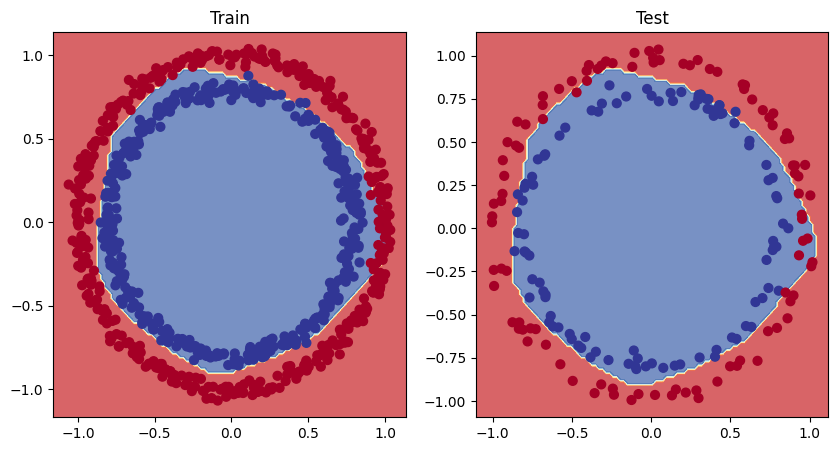

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## Replicating Nonlinear Activation Functions

In [ ]:
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

In [ ]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

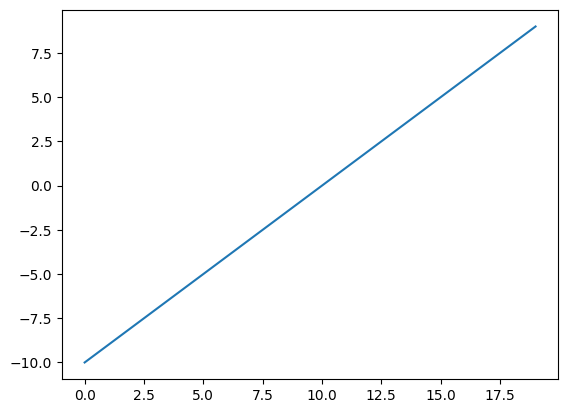

In [ ]:
plt.plot(A)

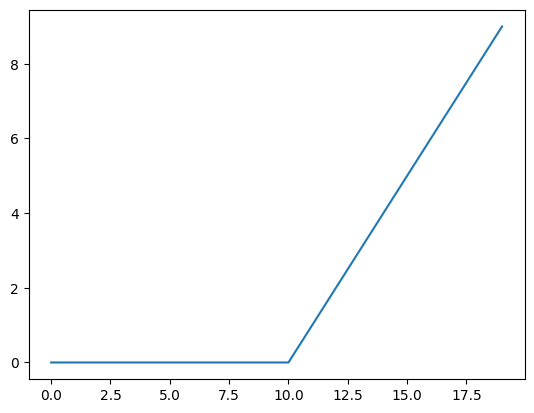

In [ ]:
plt.plot(torch.relu(A))

In [ ]:
def relu(x: torch.Tensor) -> torch.Tensor: 
  return torch.max(torch.tensor(0), x)

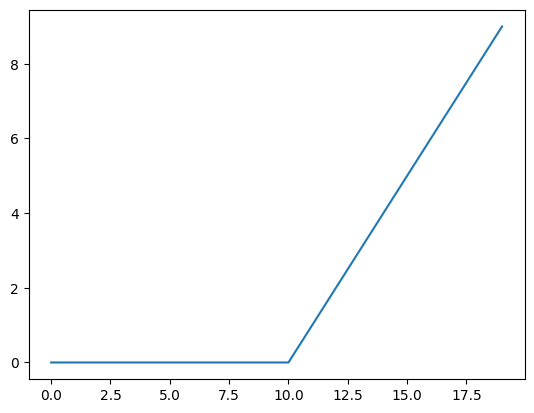

In [ ]:
plt.plot(relu(A))

In [ ]:
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

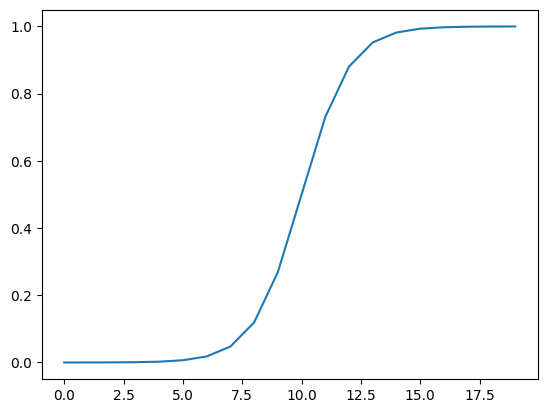

In [ ]:
plt.plot(torch.sigmoid(A))

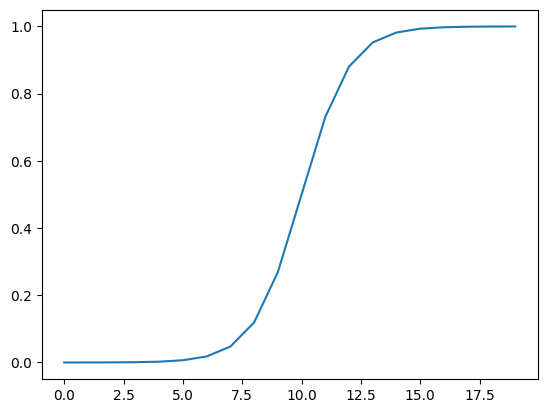

In [ ]:
plt.plot(sigmoid(A))

## Multiclass Classification

### Creating Toy Multiclass Dataset

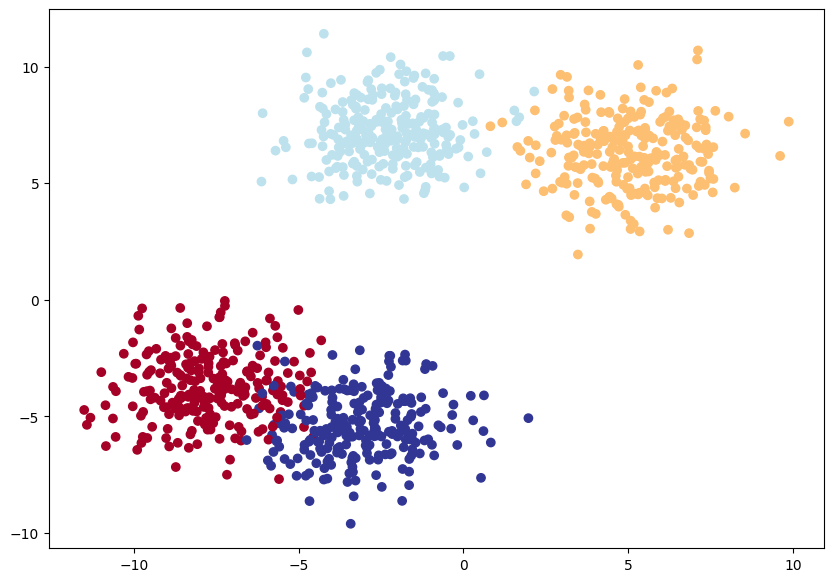

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2

# Create multiclass data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2)

# Plot Data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

In [ ]:
model_4 = BlobModel(input_features=2, 
                    output_features=4,
                    hidden_units=8).to(device)

### Loss Function and Optimizer for Multiclass Model

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

### Training/Testing Loop for Multiclass Model

In [ ]:
epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_preds)
    
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss : {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss : 1.4054, Acc: 30.75% | Test Loss: 1.2095, Test Acc: 47.50%
Epoch: 10 | Loss : 0.8341, Acc: 67.12% | Test Loss: 0.7545, Test Acc: 72.50%
Epoch: 20 | Loss : 0.6382, Acc: 76.12% | Test Loss: 0.5810, Test Acc: 80.00%
Epoch: 30 | Loss : 0.5173, Acc: 81.12% | Test Loss: 0.4798, Test Acc: 84.00%
Epoch: 40 | Loss : 0.4290, Acc: 84.00% | Test Loss: 0.4099, Test Acc: 88.00%
Epoch: 50 | Loss : 0.3702, Acc: 87.50% | Test Loss: 0.3635, Test Acc: 91.00%
Epoch: 60 | Loss : 0.3286, Acc: 91.00% | Test Loss: 0.3298, Test Acc: 93.00%
Epoch: 70 | Loss : 0.2950, Acc: 93.62% | Test Loss: 0.3027, Test Acc: 93.00%
Epoch: 80 | Loss : 0.2670, Acc: 94.62% | Test Loss: 0.2796, Test Acc: 94.00%
Epoch: 90 | Loss : 0.2427, Acc: 95.62% | Test Loss: 0.2594, Test Acc: 96.00%


### Making and Evaluating Predictions

In [ ]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)
y_preds[:10], y_blob_test[:10]

(tensor([2, 3, 1, 1, 3, 3, 0, 2, 1, 1], device='cuda:0'),
 tensor([2, 3, 1, 1, 3, 3, 0, 2, 1, 1], device='cuda:0'))

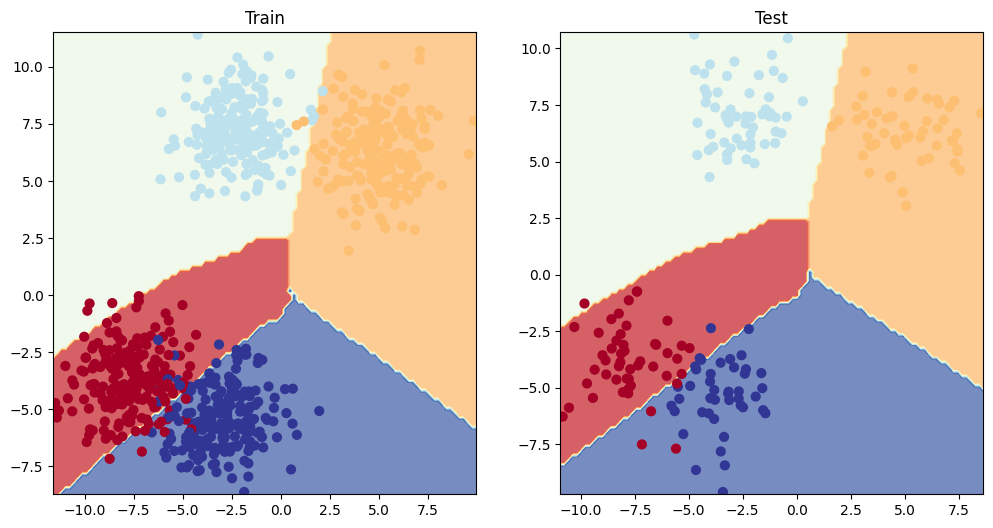

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [ ]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics
    from torchmetrics import Accuracy

In [ ]:
from torchmetrics import Accuracy

torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9600, device='cuda:0')